In [65]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, cos, sin, pi
import sympy as sp
import cmath

In [39]:
delta = 0.7
t = -1

a = 1 #lattice constant
a_0 = a/sqrt(3) # nearest neighbor distance
# onsite energies
Ea = delta
Eb = -delta

# lattice vectors
a1 = np.array([a, 0])
a2 = np.array([-a/2, a*sqrt(3)/2])
graphene_lattice = pb.Lattice(a1=a1, a2=a2)
graphene_lattice.add_sublattices(
    ('A', np.array([0, 0]), Ea), ('B', np.array([0, a_0]), Eb))  # add an atom called 'A' at position [0, 0]

# nearest-neighbor hopping
t = -1

#t2 = 0.06*1j # trivial
t2 = 0.24*1j # topological
graphene_lattice.add_hoppings(
    ([0, 0], 'A', 'B', t),
    ([-1, -1], 'A', 'B', t),
    ([0, -1], 'A', 'B', t),

    ([1, 0], 'A', 'A', t2),
    ([0, 1], 'A', 'A', t2),
    ([-1, -1], 'A', 'A', t2),

    ([1, 0], 'B', 'B', -t2),
    ([0, 1], 'B', 'B', -t2),
    ([-1, -1], 'B', 'B', -t2),
)
graphene_model = pb.Model(
    graphene_lattice,
    pb.translational_symmetry()
)

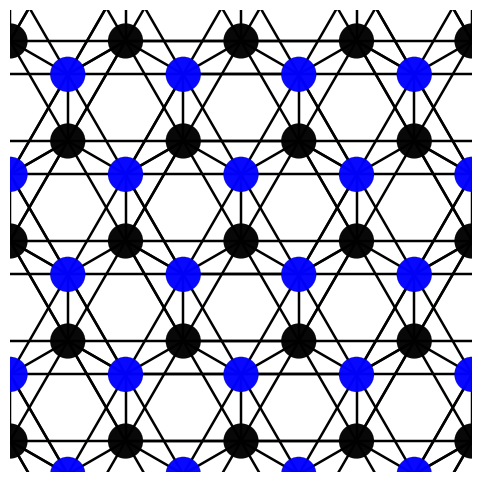

In [40]:
plt.figure(figsize=(6, 6))
graphene_model.plot(num_periods=5,
          hopping = {
  "width": 3, "color": "black", "blend" : 1,
}, sites={"cmap":["black", "blue", "red"], "blend" : 1 })
plt.gca().axis('off');
plt.xlim(-2, 2)
plt.ylim(-2, 2);

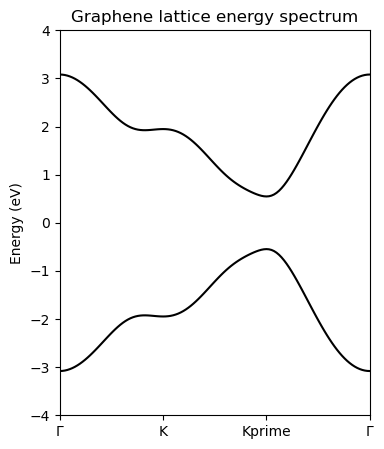

In [41]:
plt.figure(figsize=(4, 5))
solver = pb.solver.lapack(graphene_model)
G1, G2 = graphene_lattice.reciprocal_vectors()

G1 = G1[0:2]
G2 = G2[0:2]
graphene_bzone = graphene_lattice.brillouin_zone()

Gamma = np.array([0, 0])
K = 2/3*G1-1/3*G2
K = graphene_bzone[3]
Kprime = graphene_bzone[4]
M = 1/2*G1+1/2*G2
bands = solver.calc_bands(Gamma, K, Kprime, Gamma)
graphene_energies = bands.energy
k_path = bands.k_path
plt.plot(graphene_energies, color="black")

plt.xticks(k_path.point_indices, [r'$\Gamma$', 'K', 'Kprime', r'$\Gamma$'])
plt.xlim(0, len(k_path)-1)
plt.ylim(-4, 4)
plt.yticks(np.linspace(-4, 4, num=9));
plt.title("Graphene lattice energy spectrum");
plt.ylabel("Energy (eV)");

# Now we calculate the Chern number

In [311]:
solver = pb.solver.lapack(graphene_model)
chern = 0 
N = 400
chern_array = np.zeros((N, N))
N2 = 5000
for k1 in range(0, N):
    for k2 in range(0, N):
        k = G1 * k1/N + G2 * k2/N
        delta_k_1 = G1/N2
        delta_k_2 = G2/N2
        
        solver.set_wave_vector(k)
        h = graphene_model.hamiltonian.toarray()
        psi_0 = solver.eigenvectors[:, 0]
        psi_1 = solver.eigenvectors[:, 1]
        e_0 = solver.eigenvalues[0]
        e_1 = solver.eigenvalues[1]
        
        solver.set_wave_vector(k + delta_k_1)
        h_delta_1 = graphene_model.hamiltonian.toarray()
        
        solver.set_wave_vector(k + delta_k_2)
        h_delta_2 = graphene_model.hamiltonian.toarray()
        
        overlap1 = np.einsum("i, ij, j->", np.conj(psi_1), (h_delta_2-h)*N2, psi_0)/(e_0-e_1)
        overlap2 = np.einsum("i, ij, j->", np.conj(psi_0), (h_delta_1-h)*N2, psi_1)/(e_0-e_1)
        berry_curvature = -np.imag(overlap1 * overlap2)/pi/N**2
        chern += berry_curvature
        chern_array[k1, k2] = berry_curvature

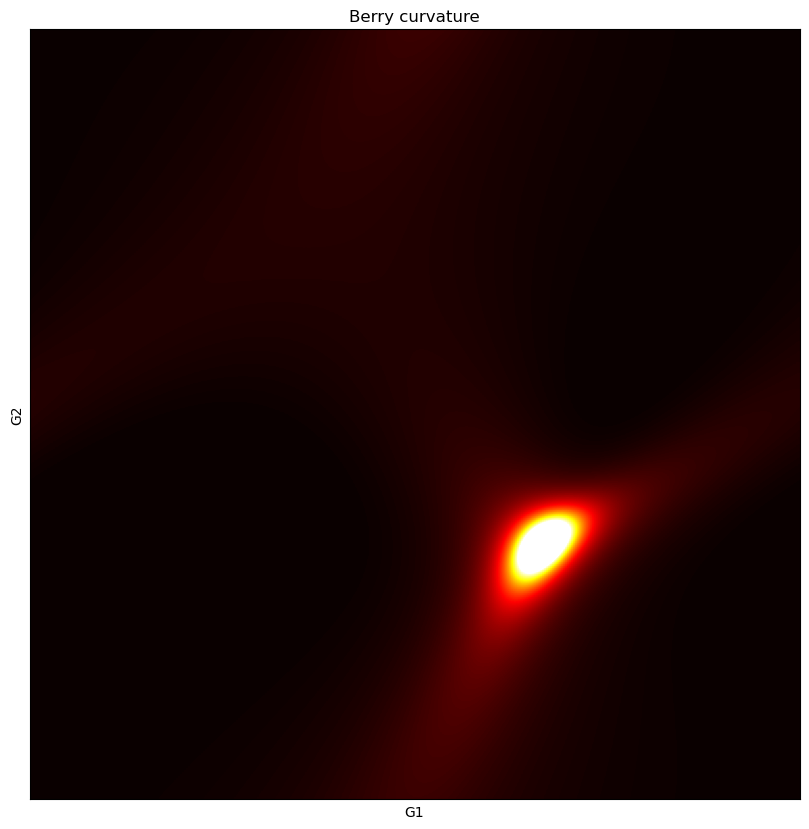

In [324]:
plt.figure(figsize=(10, 10))
plt.imshow(chern_array, vmin=0, vmax=2e-4, cmap="hot")
plt.xticks([])
plt.yticks([]);
plt.xlabel("G1")
plt.ylabel("G2");
plt.title("Berry curvature");

In [320]:
print("Chern number in topological phase: ", np.round(chern, 3))

Chern number in topological phase:  1.0


# Winding of Berry's phase

In [42]:
solver = pb.solver.lapack(graphene_model)
N2 = 500
N1 = 200
berry_phases = np.zeros(N1+1)

for k2 in range(0, N1+1):
    berry_phase = 1
    k_origin = G1 * k2/N1
    psi_last = np.zeros(2, dtype=complex) 
    psi_prev = np.zeros(2, dtype=complex) 

    for k1 in range(0, N2):
        k = k_origin + G2 * k1/N2
        delta_k_1 = G2/N2
        solver.set_wave_vector(k)
        psi_0 = solver.eigenvectors[:, 0]
        if k1 == 0:
            psi_last = psi_0
        #print(k)
        #print(k + delta_k_1)
        solver.set_wave_vector(k + delta_k_1)
        psi_1 = solver.eigenvectors[:, 0]
        if k1 == N2-1: 
            overlap = np.einsum("i, i->", np.conj(psi_0), psi_last)
        elif k1 == 0:
            overlap = np.einsum("i, i->", np.conj(psi_0), psi_1)
        else:
            overlap = np.einsum("i, i->", np.conj(psi_prev), psi_1)
        psi_prev = psi_1

        berry_phase *= overlap    
    berry_phases[k2] = cmath.phase(berry_phase)

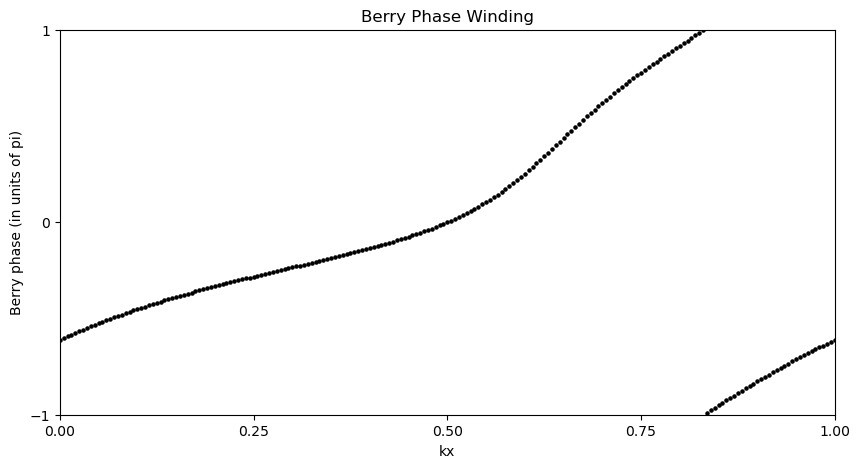

In [43]:
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi, s=5, color="black")
plt.xlim(0, 1);
plt.ylim(-1, 1);
plt.xticks([0, 0.25, 0.5, 0.75, 1]);
plt.yticks([-1, 0, 1]);
plt.title("Berry Phase Winding")
plt.xlabel("kx")
plt.ylabel("Berry phase (in units of pi)");

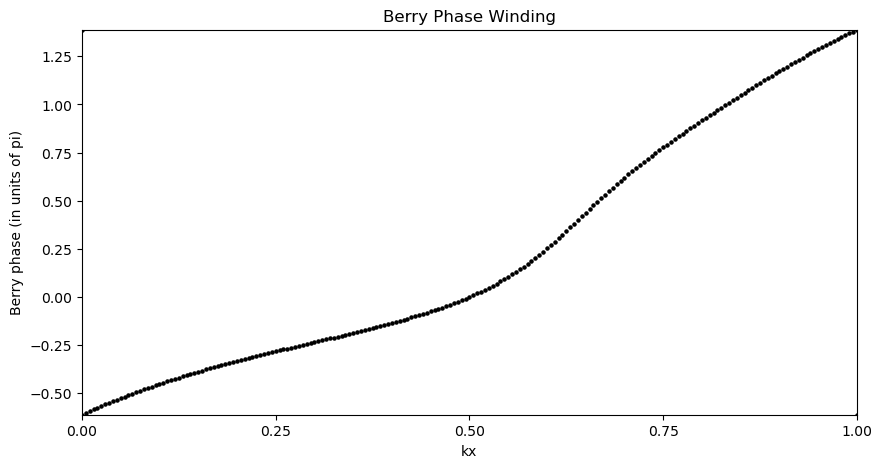

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi, s=5, color="black")
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi+2, s=5, color="black")
plt.xlim(0, 1);
plt.ylim(-berry_phases[0]/np.pi, -berry_phases[0]/np.pi+2);
plt.xticks([0, 0.25, 0.5, 0.75, 1]);
#plt.yticks([-1, 0, 1]);
plt.title("Berry Phase Winding")
plt.xlabel("kx")
plt.ylabel("Berry phase (in units of pi)");

# Berry phase winding with different wavefunction convention

In [62]:
solver = pb.solver.lapack(graphene_model)
N2 = 500
N1 = 200
berry_phases = np.zeros(N1+1)

for k2 in range(0, N1+1):
    berry_phase = 1
    k_origin = G1 * k2/N1
    psi_last = np.zeros(2, dtype=complex) 
    psi_prev = np.zeros(2, dtype=complex) 

    for k1 in range(0, N2):
        k = k_origin + G2 * k1/N2
        delta_k_1 = G2/N2
        solver.set_wave_vector(k)
        psi_0 = solver.eigenvectors[:, 0]
        
        solver.set_wave_vector(k + delta_k_1)

        rotationks = [1, exp(1j*a_0*k[1])]
        rotationkdeltas = [1, exp(1j*a_0*(k + delta_k_1)[1])]
        
        if k1 == 0:
            psi_last = psi_0

        psi_0 = einsum("i, i -> i", rotationks, psi_0)

        psi_1 = solver.eigenvectors[:, 0]
        psi_1 = einsum("i, i -> i", rotationkdeltas, psi_1)
        
        if k1 == N2-1: 
            overlap = np.einsum("i, i->", np.conj(psi_0), einsum("i, i -> i", [1, exp(1j*a_0*(k + delta_k_1)[1])], psi_last))
            #overlap = np.einsum("i, i->", np.conj(psi_0), einsum("i, i -> i", [1, exp(1j*a_0*(k_origin)[1])], psi_last))
        elif k1 == 0:
            overlap = np.einsum("i, i->", np.conj(psi_0), psi_1)
        else:
            overlap = np.einsum("i, i->", np.conj(psi_prev), psi_1)
        psi_prev = psi_1

        berry_phase *= overlap    
    berry_phases[k2] = cmath.phase(berry_phase)

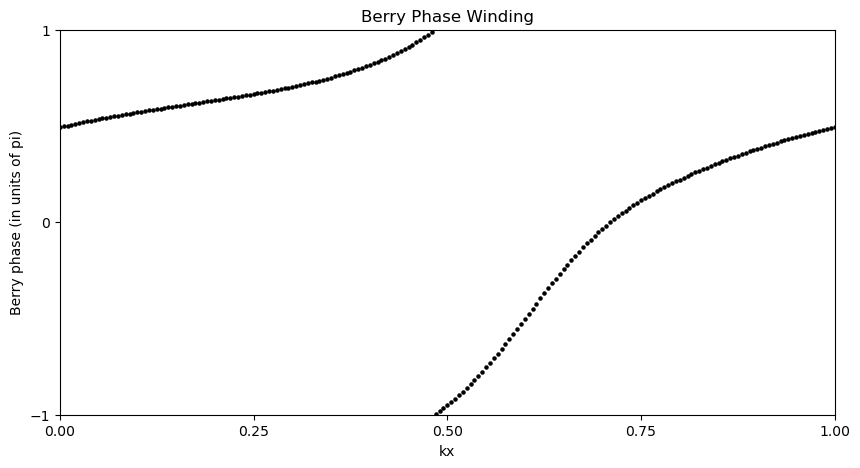

In [64]:
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi, s=5, color="black")
plt.xlim(0, 1);
plt.ylim(-1, 1);
plt.xticks([0, 0.25, 0.5, 0.75, 1]);
plt.yticks([-1, 0, 1]);
plt.title("Berry Phase Winding")
plt.xlabel("kx")
plt.ylabel("Berry phase (in units of pi)");

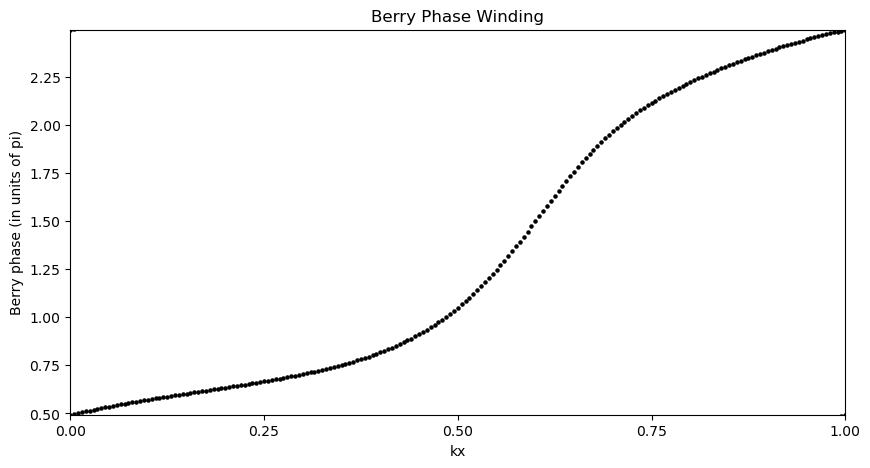

In [59]:
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi, s=5, color="black")
plt.scatter(np.linspace(0, 1, N1+1), -berry_phases/np.pi+2, s=5, color="black")

plt.xlim(0, 1);
plt.ylim(-berry_phases[0]/np.pi, -berry_phases[0]/np.pi+2);
plt.xticks([0, 0.25, 0.5, 0.75, 1]);
#plt.yticks([-1, 0, 1]);
plt.title("Berry Phase Winding")
plt.xlabel("kx")
plt.ylabel("Berry phase (in units of pi)");

# Plotting of edge states

In [178]:
delta = 0.7
t = -1

a = 1 #lattice constant
a_0 = a/sqrt(3) # nearest neighbor distance
# onsite energies
Ea = delta
Eb = -delta

# lattice vectors
N = 101
a1 = np.array([a, 0])
a2 = np.array([-a/2, a*sqrt(3)/2])
graphene_lattice = pb.Lattice(a1=a1)
for n in range(0, N):
    graphene_lattice.add_sublattices(
        (f'A{n}', np.array([0, 0])+n*a2, Ea), (f'B{n}', np.array([0, a_0])+n*a2, Eb))  # add an atom called 'A' at position [0, 0]

# nearest-neighbor hopping
t = -1

#t2 = 0.06*1j # trivial
t2 = 0.24*1j # topological
for n in range(0, N):
    graphene_lattice.add_hoppings(
        ([0], f'A{n}', f'B{n}', t),
    )
    graphene_lattice.add_hoppings(([1], f'A{n}', f'A{n}', t2))
    graphene_lattice.add_hoppings(([1], f'B{n}', f'B{n}', -t2))

    
for n in range(1, N):
    graphene_lattice.add_hoppings(([-1], f'A{n}', f'B{n-1}', t),
    ([0], f'A{n}', f'B{n-1}', t))
    graphene_lattice.add_hoppings(([-1], f'A{n}', f'A{n-1}', t2))
    graphene_lattice.add_hoppings(([-1], f'B{n}', f'B{n-1}', -t2))

for n in range(0, N-1):
    graphene_lattice.add_hoppings(([0], f'A{n}', f'A{n+1}', t2))
    graphene_lattice.add_hoppings(([0], f'B{n}', f'B{n+1}', -t2))


graphene_model = pb.Model(
    graphene_lattice,
    pb.translational_symmetry()
)


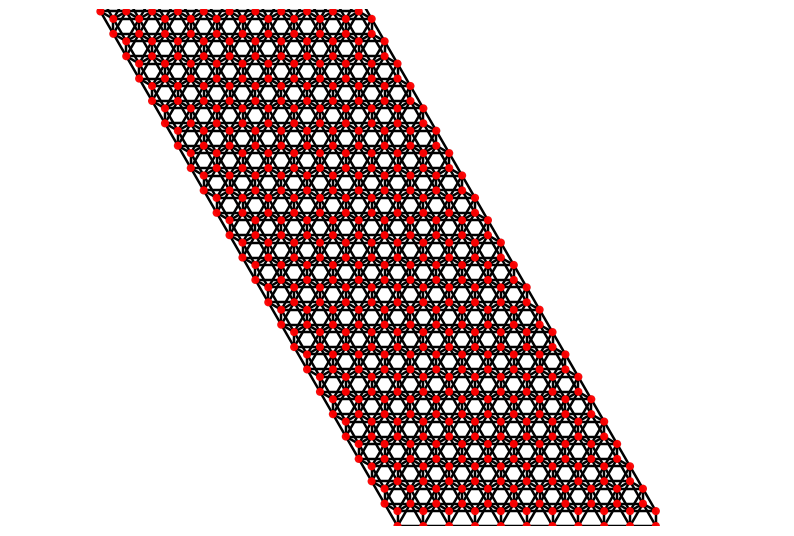

In [248]:
plt.figure(figsize=(10, 10))
graphene_model.plot(num_periods=5,
          hopping = {
  "width": 3, "color": "black", "blend" : 1,
}, sites={"cmap" : ["red"], "blend" : 1 })
plt.gca().axis('off');
plt.xlim(-20, 10)
plt.ylim(0, 20);

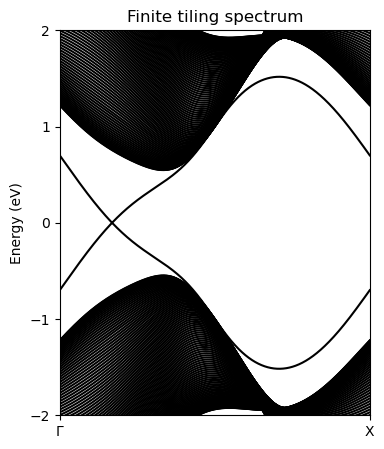

In [241]:
plt.figure(figsize=(4, 5))
solver = pb.solver.lapack(graphene_model)
G1 = graphene_lattice.reciprocal_vectors()[0]

G1 = G1[0:2]
graphene_bzone = graphene_lattice.brillouin_zone()

Gamma = np.array([0, 0])
X = G1
bands = solver.calc_bands(Gamma, -X, step=X[0]/1000)
graphene_energies = bands.energy
k_path = bands.k_path
plt.plot(graphene_energies, color="black")

plt.xticks(k_path.point_indices, [r'$\Gamma$', 'X'])
plt.xlim(0, len(k_path)-1)
plt.ylim(-2, 2)
plt.yticks(np.linspace(-2, 2, num=5));
plt.title("Finite tiling spectrum");
plt.ylabel("Energy (eV)");

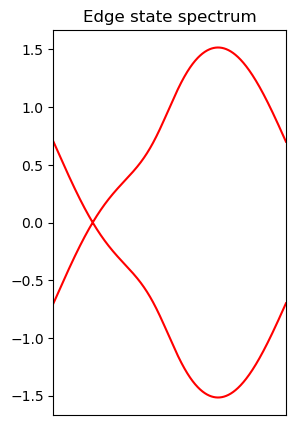

In [183]:
plt.figure(figsize=(3, 5))
plt.plot(graphene_energies[:, 100], color="red")
plt.plot(graphene_energies[:, 101], color="red")
plt.xlim(0, graphene_energies.shape[0]-1);
plt.xticks([]);
plt.title("Edge state spectrum");

In [184]:
solver = pb.solver.lapack(graphene_model)
solver.set_wave_vector(-X/4)

In [216]:
sublattice_sum_1 = ((np.abs(solver.eigenvectors[:, 101])**2)[0::2] + (np.abs(solver.eigenvectors[:, 101])**2)[1::2])
sublattice_sum_2 = ((np.abs(solver.eigenvectors[:, 100])**2)[0::2] + (np.abs(solver.eigenvectors[:, 100])**2)[1::2])

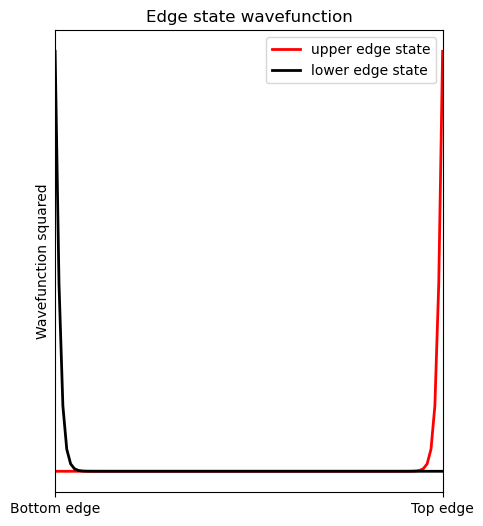

In [240]:
plt.figure(figsize=(5, 6))
plt.plot(range(0, N), sublattice_sum_1, color="red", linewidth=2, label="upper edge state")
plt.plot(range(0, N), sublattice_sum_2, color="black", linewidth=2, label="lower edge state")
plt.xlim(0, N-1);
plt.xticks([0, N-1], ["Bottom edge", "Top edge"]);
plt.yticks([]);
plt.ylabel("Wavefunction squared")
plt.title("Edge state wavefunction")
plt.legend();